# Handwritten letters recognizer

In [10]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

In [11]:
# from tensorflow import keras
import tensorflow as tf 
from keras.models import load_model

## Load trained models
I trained two models:
1. *model_all* - Uppercase and lowercase letters and digits
2. *model_capital* - Uppercase letters only

### NN Model - All letters and digits

In [56]:
classes_all = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
num_classes_all = 47 
img_size = 28

In [57]:
model_all = tf.keras.models.load_model('./models/model2-full-all-20-epochs.h5')

### NN Model - Capital letters

In [58]:
classes_capital = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
num_classes_capital = 26
img_size = 28

In [59]:
model_capital = tf.keras.models.load_model('./models/model2-full-capital-20-epochs.h5')

In [60]:
type(model_capital)

tensorflow.python.keras.engine.sequential.Sequential

## Custom image to EMNIST format
Developed in *image-to-emnist.ipynb*

Resizing and doing some image filterting on a custom image, so that it fits in the input of the classifier.

In [46]:
def image_to_emnist(img):
    img = img.resize((28, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    
    img_canvas = Image.new('L', (28, 28), (255))
    img_canvas.paste(img)
    
    img_data = list(img_canvas.getdata())

    #Normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    img_normalized = [(255 - x) * 1.0 / 255.0 for x in img_data]
    
    return img_normalized

## Testing

In [61]:
def run_prediction(img, model):
    result = np.argmax(model.predict(img))
    confidence = max(model.predict(img)[0])
    
    return result, confidence

In [212]:
def show_prediction(classes):
    plt.imshow(img_emnist.reshape(28,28), cmap='Greys_r')
    print('Prediction:', classes[result], ', Confidence:', confidence)

### Single letter
Single letters that are in the center of the picure are easy to classify. Even pictures that are very different from the training set.

In [265]:
imgPath = './sample_images/m_kasova.jpg'
img = Image.open(imgPath)

img_emnist = np.array(image_to_emnist(img)).reshape(1,28,28,1)

In [266]:
result, confidence = run_prediction(img_emnist, model_capital)

Prediction: M , Confidence: 0.13035248


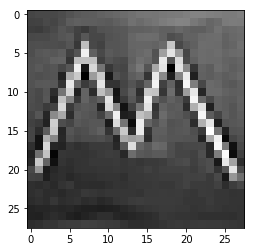

In [267]:
show_prediction(classes_capital)

### Larger pictures - Sliding window
If we have a larger picture with multiple letters inside, we need a way to find and classify each letter.

I've implemented my own version of a "sliding window".

#### Sliding window
Multiple windows of different sizes are moving over different sectiosn of the image and recording the prediciton and cofindence. There is also a treshold which each prediction must pass to be recorded.

In [306]:
def predict_best_sliding_window(model, classes):
    # Window sizes and stride are hardcoded, but they can be chosen depening on the image size and the speed of passing
    windowSizes = [120, 100, 80] 
    stride = 20
    treshold = 0.2

    width = img.size[0]
    height = img.size[1]

    found = []

    for windowSize in windowSizes:
        for y in range(0, int(height) - windowSize + 1, stride):
            for x in range(0, int(width) - windowSize + 1, stride):
                newWindow = img.crop((x, y, x + windowSize, y + windowSize))
                emnistImg = np.array(image_to_emnist(newWindow))

                currLabel, currConfidence = run_prediction(emnistImg.reshape(1,28,28,1), model)

                if currConfidence > treshold:
                    found.append({'char': classes[currLabel], 'conf': currConfidence, 'x': x, 'y': y, 'size': windowSize})
    
    return found

#### Pick best detections and sort alphabetically
There may be a lot of different image sections of the same letter, that differ slithly in their x and y position in the image. To solve the problem we simply employ the strategy of:
1. When two image sections are overlapping, we choose the section with the larger size.
2. When two image sections of the same size are overlapping, we choose the one with the bigger confidence.


In [256]:
def remove_overlapping_windows(windows):
    overlapRate = 1.8
    
    keepWindow = [True] * len(windows)

    for i in range(len(windows)):
        for j in range(i+1, len(windows)):
            # If the images are of the same size - choose the one with larger confidence
            if windows[i]['size'] == windows[j]['size']:
                # Check for overlapping between the pictures
                if abs(windows[i]['x'] - windows[j]['x']) < windows[i]['size'] / overlapRate and abs(windows[i]['y'] - windows[j]['y']) < windows[i]['size'] / overlapRate:
                    if windows[i]['conf'] > windows[j]['conf']:
                        keepWindow[j] = False
                    else:
                        keepWindow[i] = False
            # IF the images are smaller than the current one, prefer the larger
            else:
                # Check for overlapping between the pictures
                if abs(windows[i]['x'] - windows[j]['x']) < windows[i]['size'] / overlapRate and abs(windows[i]['y'] - windows[j]['y']) < windows[i]['size'] / overlapRate:
                    keepWindow[j] = False

    #Return the best picture regions that do not overlap 
    result = []                
    for i in range(len(windows)):
        if keepWindow[i]:
            result.append(windows[i])

    return result

#### Sorting the found letters alphabetically 

In [257]:
def sort_result(windows):
        result = []          
        
        for win in windows:
            result.append(win['char'])

        print(sorted(result))

#### Showing the image sections with the larger confidence, that are also not overlapping.

In [258]:
def show_windows(windows):
    
    for win in windows:
        
        newWindow = img.crop((win['x'], win['y'], win['x'] + win['size'], win['y'] + win['size']))
        display(newWindow)
        print('Predicted:', win['char'], 'Confidence:', win['conf'], 'Window size:', win['size'])
        print()

#### Test 1 - Multiple letters, drawn by myself on paint

In [271]:
imgPath = './sample_images/letters_capital.png'
img = Image.open(imgPath)

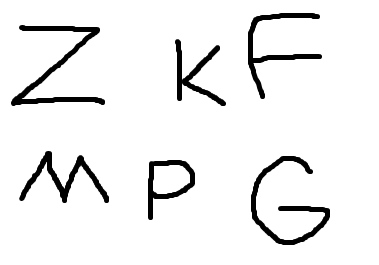

['F', 'G', 'K', 'M', 'P', 'Z']

Best windows:


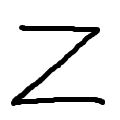

Predicted: Z Confidence: 0.99998295 Window size: 120



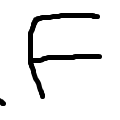

Predicted: F Confidence: 0.9996438 Window size: 120



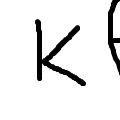

Predicted: K Confidence: 0.99675304 Window size: 120



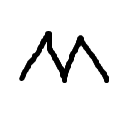

Predicted: M Confidence: 0.9999831 Window size: 120



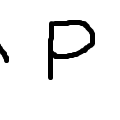

Predicted: P Confidence: 0.99932194 Window size: 120



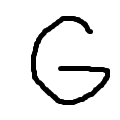

Predicted: G Confidence: 0.999416 Window size: 120



In [272]:
bestWindows = predict_best_sliding_window(model_capital, classes_capital)
filteredWindows = remove_overlapping_windows(bestWindows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

#### Test 2 - Letters of different sizes

In [273]:
imgPath = './sample_images/letters-sizes.png'
img = Image.open(imgPath)

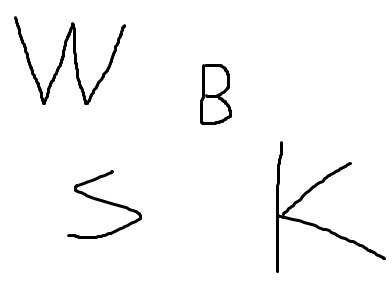

['B', 'K', 'S', 'W']

Best windows:


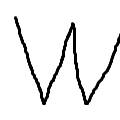

Predicted: W Confidence: 0.99968684 Window size: 120



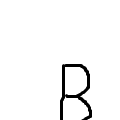

Predicted: B Confidence: 0.97291934 Window size: 120



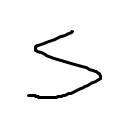

Predicted: S Confidence: 0.9936847 Window size: 120



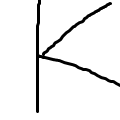

Predicted: K Confidence: 0.9999609 Window size: 120



In [274]:
bestWindows = predict_best_sliding_window(model_capital, classes_capital)
filteredWindows = remove_overlapping_windows(bestWindows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

#### Test 3 - Letters from a picture
*Didn't expected to classify them all correctly...*

In [291]:
imgPath = './sample_images/letters-photo.jpg'
img = Image.open(imgPath)

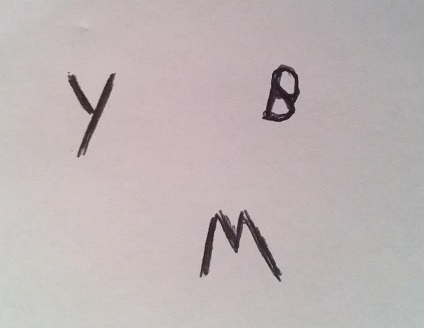

['B', 'M', 'Y']

Best windows:


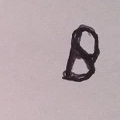

Predicted: B Confidence: 0.70715016 Window size: 120



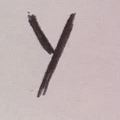

Predicted: Y Confidence: 0.7416248 Window size: 120



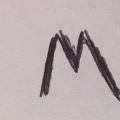

Predicted: M Confidence: 0.699065 Window size: 120



In [292]:
bestWindows = predict_best_sliding_window(model_capital, classes_capital)
filteredWindows = remove_overlapping_windows(bestWindows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

#### Test 4 - More letters from a picture 

In [307]:
imgPath = './sample_images/more-letters.jpg'
img = Image.open(imgPath)

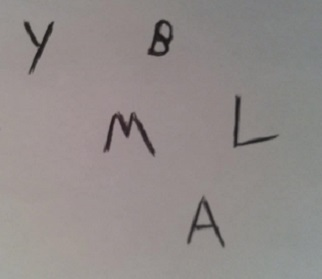

['A', 'L', 'Q']

Best windows:


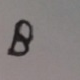

Predicted: Q Confidence: 0.21685354 Window size: 80



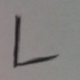

Predicted: L Confidence: 0.2373337 Window size: 80



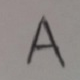

Predicted: A Confidence: 0.2818911 Window size: 80



In [308]:
bestWindows = predict_best_sliding_window(model_capital, classes_capital)
filteredWindows = remove_overlapping_windows(bestWindows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

By adding some more letters, wealso took the picture from a diffrent angle, resized it differently and changed even made it darker. That changed the window sections completly, giving us classification with substantially lower confidence.  

# Summary and future work
The task of classifying handwritten letters is obviously very large. 

I've choosen the aproach of building a simple CNN that classifies the EMNIST letters and then using that classificator on different regions of the picture to collect the best predictions.

The CNN classificator is doing a good enough job on the style of the EMNIST pictures, which are centered and have a clear background. But with "real life" pictures the situation is different.

#### 1. Problem: The background is not clear
I think the best approach would be to preprocess the pictures further, by sharpening the letters. There is some image filtering and max pooling, but it seems like it's not enough.

#### 2. Problem: Precise object detection
The biggest problem with my version of the sliding window, is that I'm giving my classifier a lot of pictures where the letter is not centered, or even pieces of different letters are caught in the opposite corners. The training data has only centered pictures and it hasn't learned to give very low scores on non-centered ones. The result is that often the highest confidence belongs to such pictures where the letters is not even there... The best approach would be to employ some kind of "region proposals" - which will first find regions of centered letters and then will classify them.

### Additional features

#### 1. Rotated letters
The task wasn't clear enough whether all the letters will have the same rotation or each letter may have a different one.
- If it's the latter, then just rotating some of the training examples to 10,15,20.. degress left and right should largely solve the problem.
- If they all have the same rotation, another approach may be to first find where are the letters, and rotate the entire picture until achievig optimal result.

#### 2. Upper and lower casing
Some of the letters are identical in both their forms (e.g. z-Z, p-P). A good approach would be, in the cases of such letters to check on the left and right, whether there are other letters and judge by the size of them if the current letter is lowercase or not.


